# Working with JP files and attempts to detide our WCVI model boundary conditions obtained from JP

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib as mpl
from salishsea_tools import viz_tools, geo_tools,nc_tools

### JP has three types of model output data 

    1) the output called *_grid_2D.nc
    2) the output called *_grid_2D_hourly.nc
    3) each of the variable outputs (scalars in grid_T.nc and a file each for grid_U.nc, grid_V.nc, grid_W.nc)

In [2]:
f_name_2D = '/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20160513_00874080_grid_2D.nc'

f_name_hourly = '/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20160513_00874080_grid_2D_hourly.nc'

fname_T = '/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20160513_00874080_grid_T.nc'

#### Let's look into the grid_2D file

In [3]:
nc_tools.show_variables(nc.Dataset(f_name_2D))
nc_tools.show_dimensions(nc.Dataset(f_name_2D))

odict_keys(['nav_lon', 'nav_lat', 'time_counter', 'time_counter_bnds', 'sossheig', 'sosstsst', 'sosaline', 'vozocrtx', 'vomecrty', 'sobarstf', 'sohefldo', 'soshfldo', 'somxl010'])
<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 715

<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 1021

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 1

<class 'netCDF4._netCDF4.Dimension'>: name = 'bnds', size = 2



#### Now into the grid_2D hourly file

In [4]:
nc_tools.show_variables(nc.Dataset(f_name_hourly))
nc_tools.show_dimensions(nc.Dataset(f_name_hourly))

odict_keys(['nav_lon', 'nav_lat', 'time_counter', 'sossheig', 'sosstsst', 'sosaline', 'vozocrtx', 'vomecrty', 'sobarstf', 'sohefldo', 'soshfldo', 'somxl010'])
<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 715

<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 1021

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 24



#### Now let's see what exists in the normal file which has daily output

In [5]:
nc_tools.show_variables(nc.Dataset(fname_T))
nc_tools.show_dimensions(nc.Dataset(fname_T))

odict_keys(['nav_lon', 'nav_lat', 'deptht', 'time_counter', 'time_counter_bnds', 'votemper', 'vosaline', 'sosstsst', 'sosaline', 'sossheig', 'sowaflup', 'sowaflcd', 'sosalflx', 'sohefldo', 'soshfldo', 'somxl010', 'somixhgt', 'soicecov', 'sohefldp', 'sosafldp', 'sowafldp', 'sobowlin'])
<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 715

<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 1021

<class 'netCDF4._netCDF4.Dimension'>: name = 'deptht', size = 50

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 1

<class 'netCDF4._netCDF4.Dimension'>: name = 'bnds', size = 2



ncdump in the terminal for each of the T files (daily outputs) reveals that the origin of the time counter for each of the files are the same (time_counter:units = "seconds since 2014-9-15 00:00:00"). That makes our life easy to use the nco tools to concatenate the variables we need in a different file with time as our record dimension. We need to do this to apply the tide filter.


The U and V outputs (daily) is also expected to have something similar.

### Used ncrcat to concatenate 3 such T files (daily outputs) to make one file which has a 3 day output

[see usage of ncrcat here](http://research.jisao.washington.edu/data_sets/nco/#example9)

In [6]:
fname_cat = '/home/ssahu/saurav/JP_BC/cat_3_days_T.nc'

In [7]:
nc_tools.show_variables(nc.Dataset(fname_cat))
nc_tools.show_dimensions(nc.Dataset(fname_cat))

odict_keys(['nav_lon', 'nav_lat', 'deptht', 'time_counter', 'time_counter_bnds', 'votemper', 'vosaline', 'sosstsst', 'sosaline', 'sossheig', 'sowaflup', 'sowaflcd', 'sosalflx', 'sohefldo', 'soshfldo', 'somxl010', 'somixhgt', 'soicecov', 'sohefldp', 'sosafldp', 'sowafldp', 'sobowlin'])
<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 1021

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 715

<class 'netCDF4._netCDF4.Dimension'>: name = 'deptht', size = 50

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 3

<class 'netCDF4._netCDF4.Dimension'>: name = 'bnds', size = 2



In [8]:
from salishsea_tools import grid_tools, tidetools
#import timeseries_extras


with nc.Dataset(fname_cat, 'r') as cncat:
    unfiltered_t = cncat.variables['votemper'][:]; unfiltered_sa = cncat.variables['vosaline'][:];
    time_JP =  cncat.variables['time_counter'][:]; depth = cncat.variables['deptht'][:];
    
    
print(unfiltered_t.shape, unfiltered_sa.shape, time_JP.shape, depth.shape)



# Filter tides 
#variables = ['vozocrtx', 'vomecrty']  # Just the velocities
#dims = ['depth']  # Just the horizontal currents
#for variable in variables:
#    for dim in dims:
filtered_t = tidetools.filter_timeseries(unfiltered_t, method='doodson')

(3, 50, 1021, 715) (3, 50, 1021, 715) (3,) (50,)


In [9]:

filtered_t_mean = np.mean(filtered_t, axis = (2,3))

unfiltered_t_mean = np.mean(unfiltered_t, axis=(2,3))

print(unfiltered_t_mean.shape)

(3, 50)


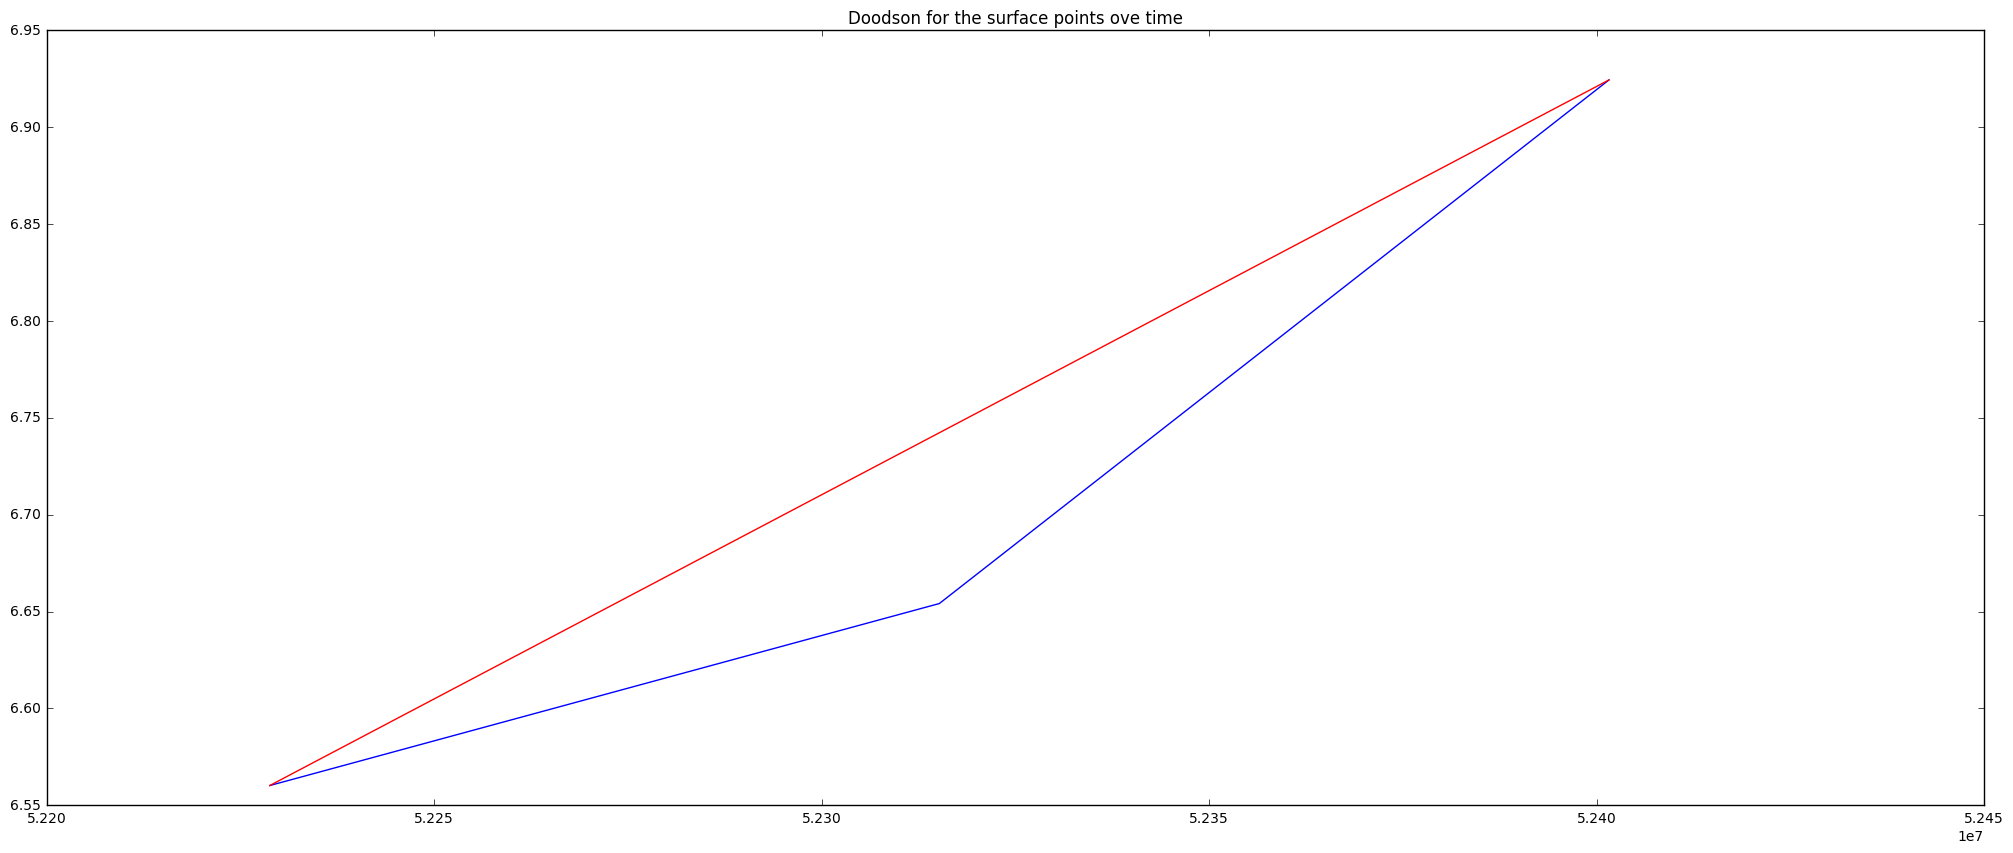

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))

plt.plot(time_JP, unfiltered_t_mean[:,0],'-b') #

plt.plot(time_JP, filtered_t_mean[:,0],'-r')

plt.title('Doodson for the surface points ove time')

plt.show()

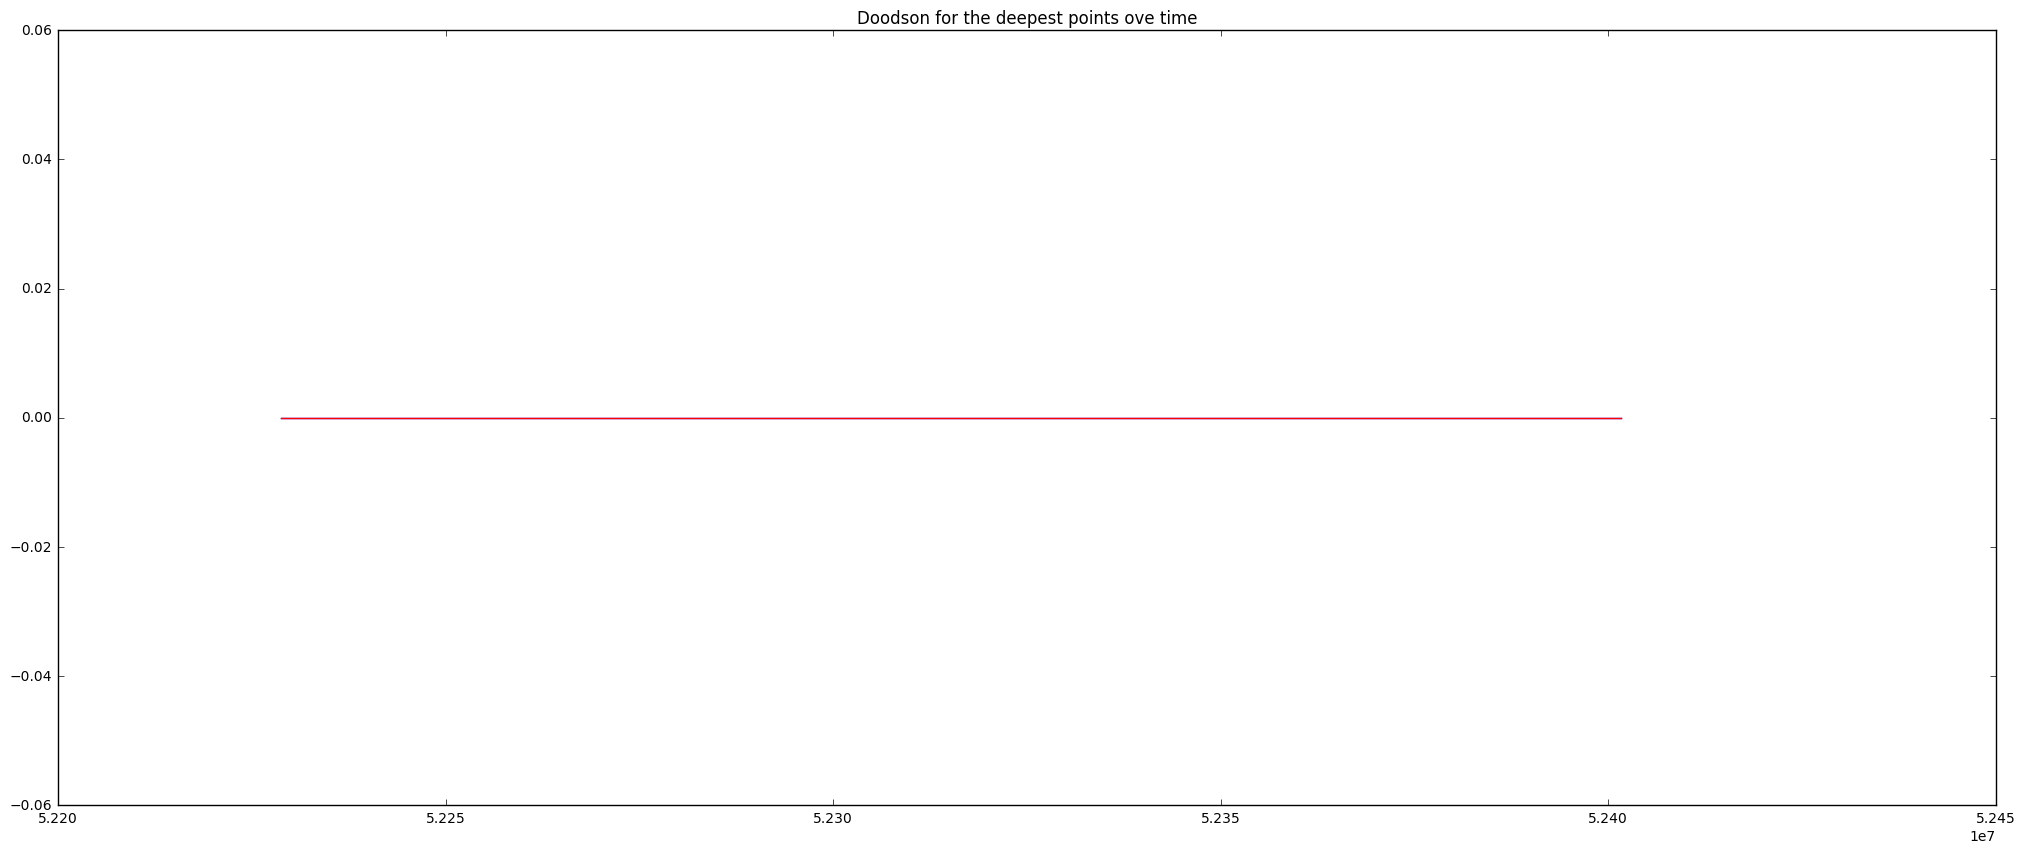

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))

plt.plot(time_JP, unfiltered_t_mean[:,49],'-b') #

plt.plot(time_JP, filtered_t_mean[:,49],'-r')

plt.title('Doodson for the deepest points ove time')

plt.show()

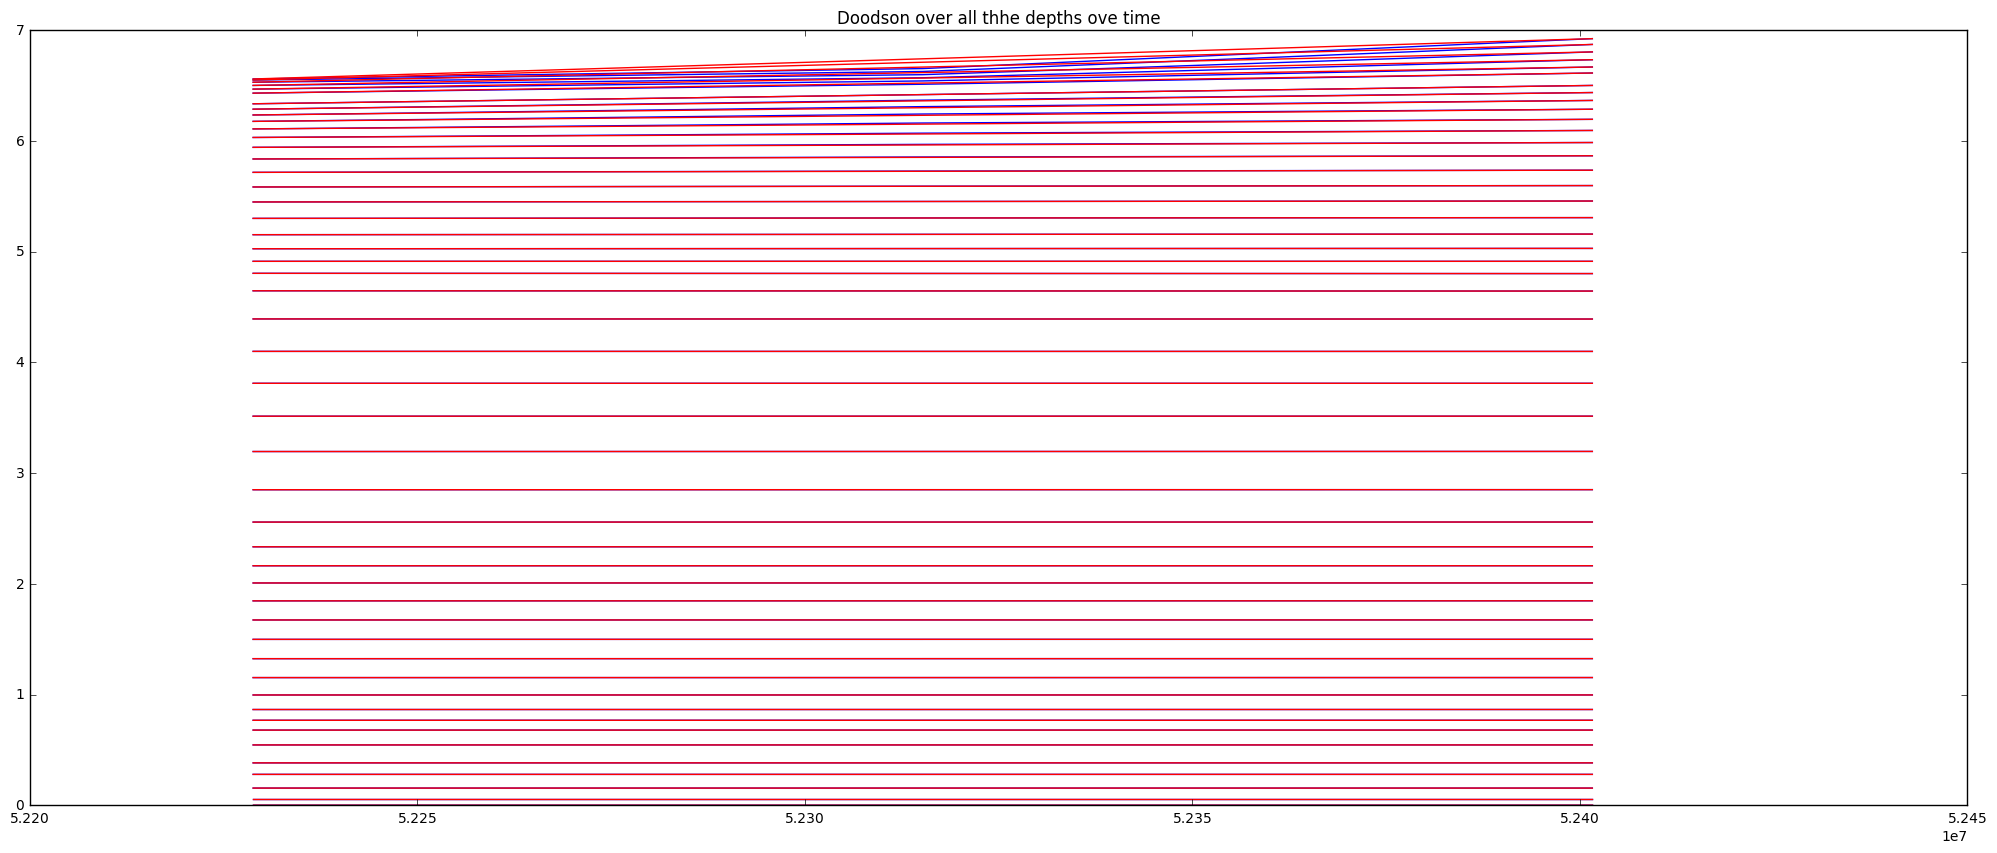

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))

plt.plot(time_JP, unfiltered_t_mean[:,:],'-b') #

plt.plot(time_JP, filtered_t_mean[:,:],'-r')

plt.title('Doodson over all thhe depths ove time')

plt.show()

#### Clealy the doodson filter is inappropriate for such detiding from daily outputs whereas it worked quite well for the hourly outputs (but the data was 2D so we can't use those as our boundary conditions for our model)


The doodson needs at least 39 data points and if less data are provided it will simply make a linear interpolation using the end points as seen in the picture above. But it would be improper to think that even we make our 39 day worth of data and run it through Doodson it would treat the days as hours and do the filtering which means I would lose information on a 6day timescale whereas the tidal frequency is maximum like a day or two. 

The solution would be to make a box filter and run it ove our data (at each depth). 

##Confirm at the meeting

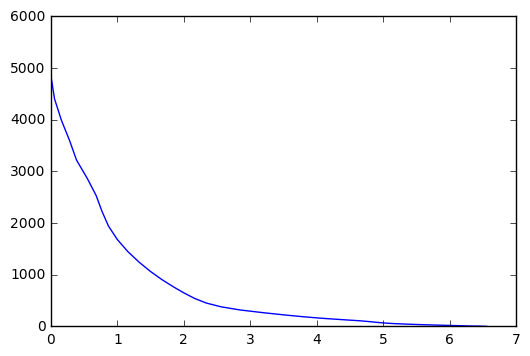

In [13]:
#tempreature profile with depth

plt.plot(unfiltered_t_mean[0,:],depth,'-b')
plt.show()

##### Looking at how the doodson filter works for more than 39 data points (43 days daily data concatenated over thw time dimension)

In [3]:
fname_cat_42 = '/home/ssahu/saurav/JP_BC/cat_42_days_T.nc'

In [4]:
nc_tools.show_variables(nc.Dataset(fname_cat_42))
nc_tools.show_dimensions(nc.Dataset(fname_cat_42))

odict_keys(['nav_lon', 'nav_lat', 'deptht', 'time_counter', 'time_counter_bnds', 'votemper', 'vosaline', 'sosstsst', 'sosaline', 'sossheig', 'sowaflup', 'sowaflcd', 'sosalflx', 'sohefldo', 'soshfldo', 'somxl010', 'somixhgt', 'soicecov', 'sohefldp', 'sosafldp', 'sowafldp', 'sobowlin'])
<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 1021

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 715

<class 'netCDF4._netCDF4.Dimension'>: name = 'deptht', size = 50

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 43

<class 'netCDF4._netCDF4.Dimension'>: name = 'bnds', size = 2



In [5]:
from salishsea_tools import grid_tools, tidetools
#import timeseries_extras


with nc.Dataset(fname_cat_42, 'r') as cncat_42:
    unfiltered_t_42 = cncat_42.variables['votemper'][:]; unfiltered_sa_42 = cncat_42.variables['vosaline'][:];
    time_JP_42 =  cncat_42.variables['time_counter'][:]; depth_42 = cncat_42.variables['deptht'][:];
    
    
print(unfiltered_t_42.shape, unfiltered_sa_42.shape, time_JP_42.shape, depth_42.shape)

(43, 50, 1021, 715) (43, 50, 1021, 715) (43,) (50,)


In [17]:
# Filter tides 
#variables = ['vozocrtx', 'vomecrty']  # Just the velocities
#dims = ['depth']  # Just the horizontal currents
#for variable in variables:
#    for dim in dims:
filtered_t_42 = tidetools.filter_timeseries(unfiltered_t_42[:20,...], method='doodson')

In [18]:

filtered_t_mean_42 = np.mean(filtered_t_42, axis = (2,3))

unfiltered_t_mean_42 = np.mean(unfiltered_t_42, axis=(2,3))

print(unfiltered_t_mean_42.shape)

(43, 50)


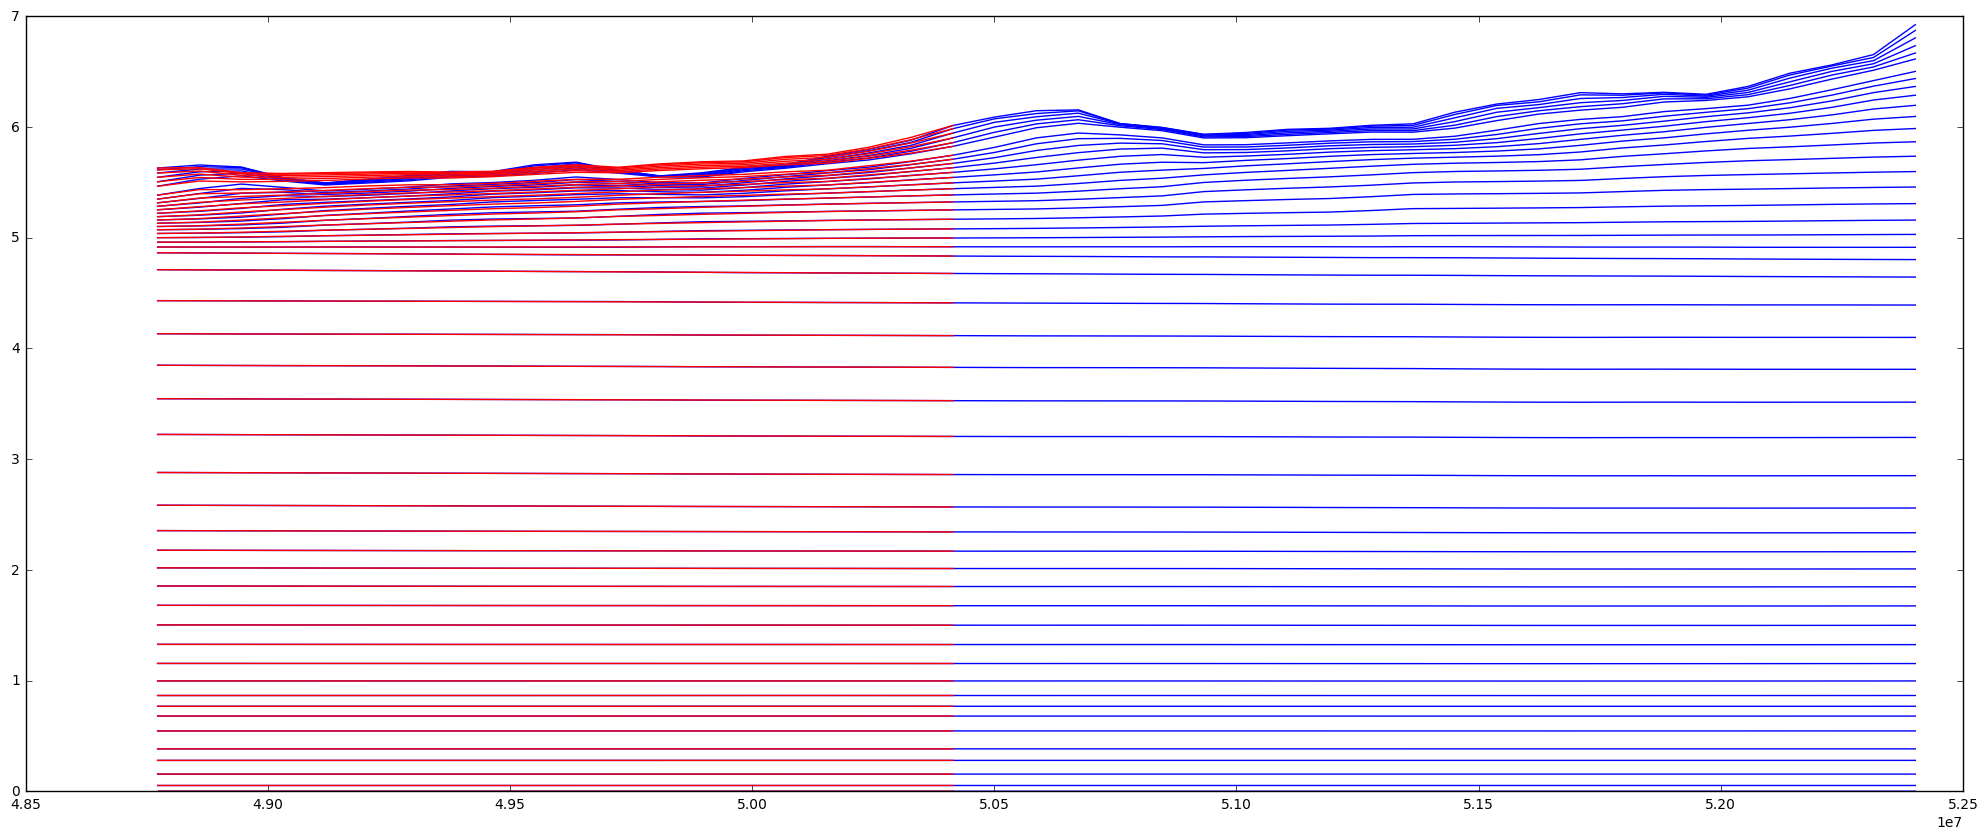

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))

plt.plot(time_JP_42, unfiltered_t_mean_42,'-b') #

plt.plot(time_JP_42[:20], filtered_t_mean_42,'-r')


plt.show()

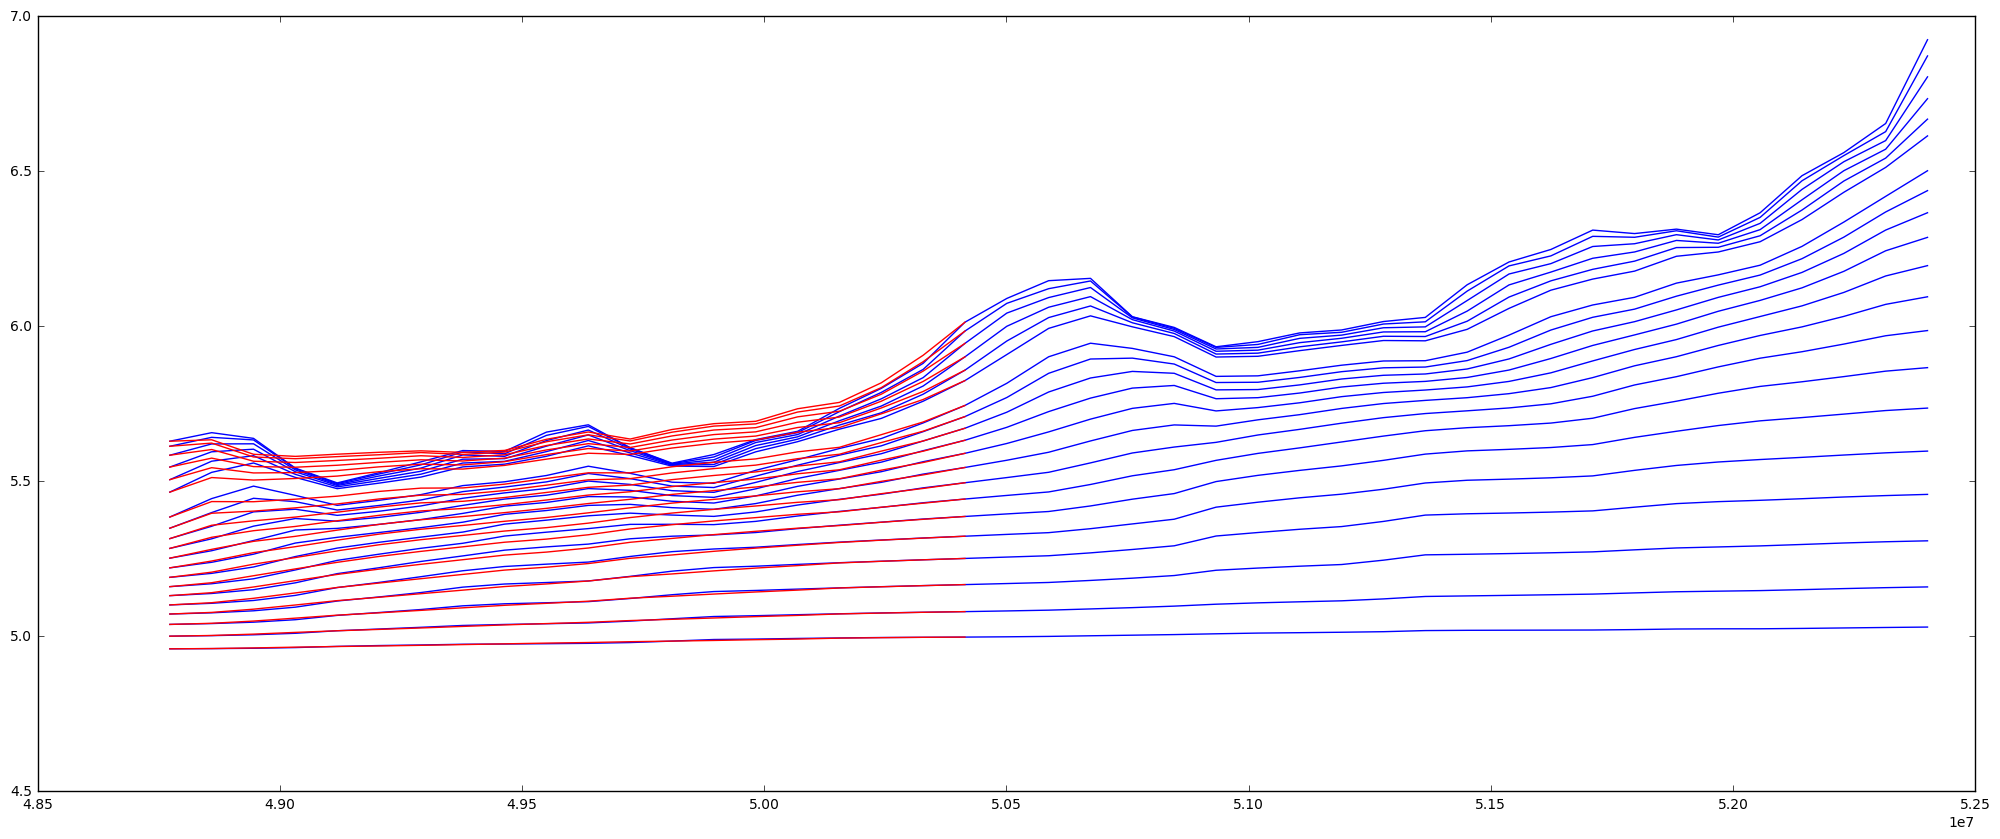

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))

plt.plot(time_JP_42, unfiltered_t_mean_42[:,:20],'-b') 

plt.plot(time_JP_42[:20], filtered_t_mean_42[:,:20],'-r')


plt.show()

##### Playing around to see if the memory error gets done away if we do it not for all depth levels since the lower levels are the same even after using the filter

In [6]:
# Filter tides 
#variables = ['vozocrtx', 'vomecrty']  # Just the velocities
#dims = ['depth']  # Just the horizontal currents
#for variable in variables:
#    for dim in dims:
filtered_t_42_memory = tidetools.filter_timeseries(unfiltered_t_42[:,:20,...], method='doodson')

In [7]:

filtered_t_mean_42_memory = np.mean(filtered_t_42_memory, axis = (2,3))

unfiltered_t_mean_42 = np.mean(unfiltered_t_42[:,:20,...], axis=(2,3))

print(unfiltered_t_mean_42.shape)

(43, 20)


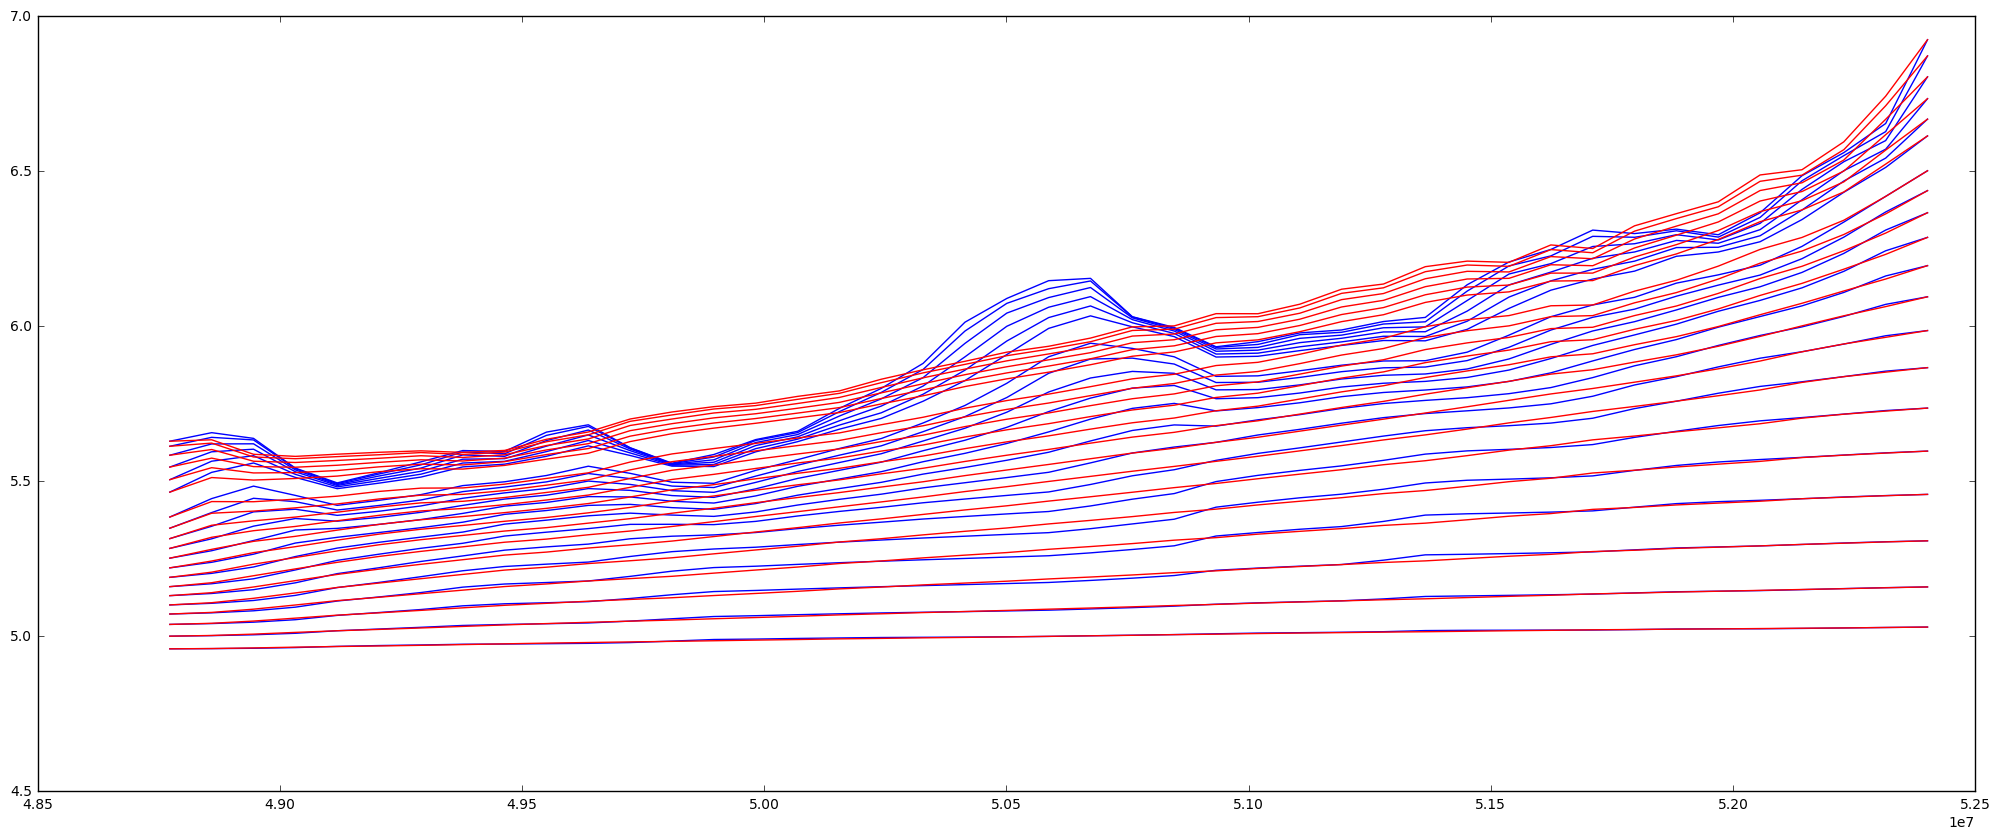

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))

plt.plot(time_JP_42, unfiltered_t_mean_42,'-b') #

plt.plot(time_JP_42, filtered_t_mean_42_memory,'-r')


plt.show()